Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0037932342..26608.965].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0037932342..26608.965].


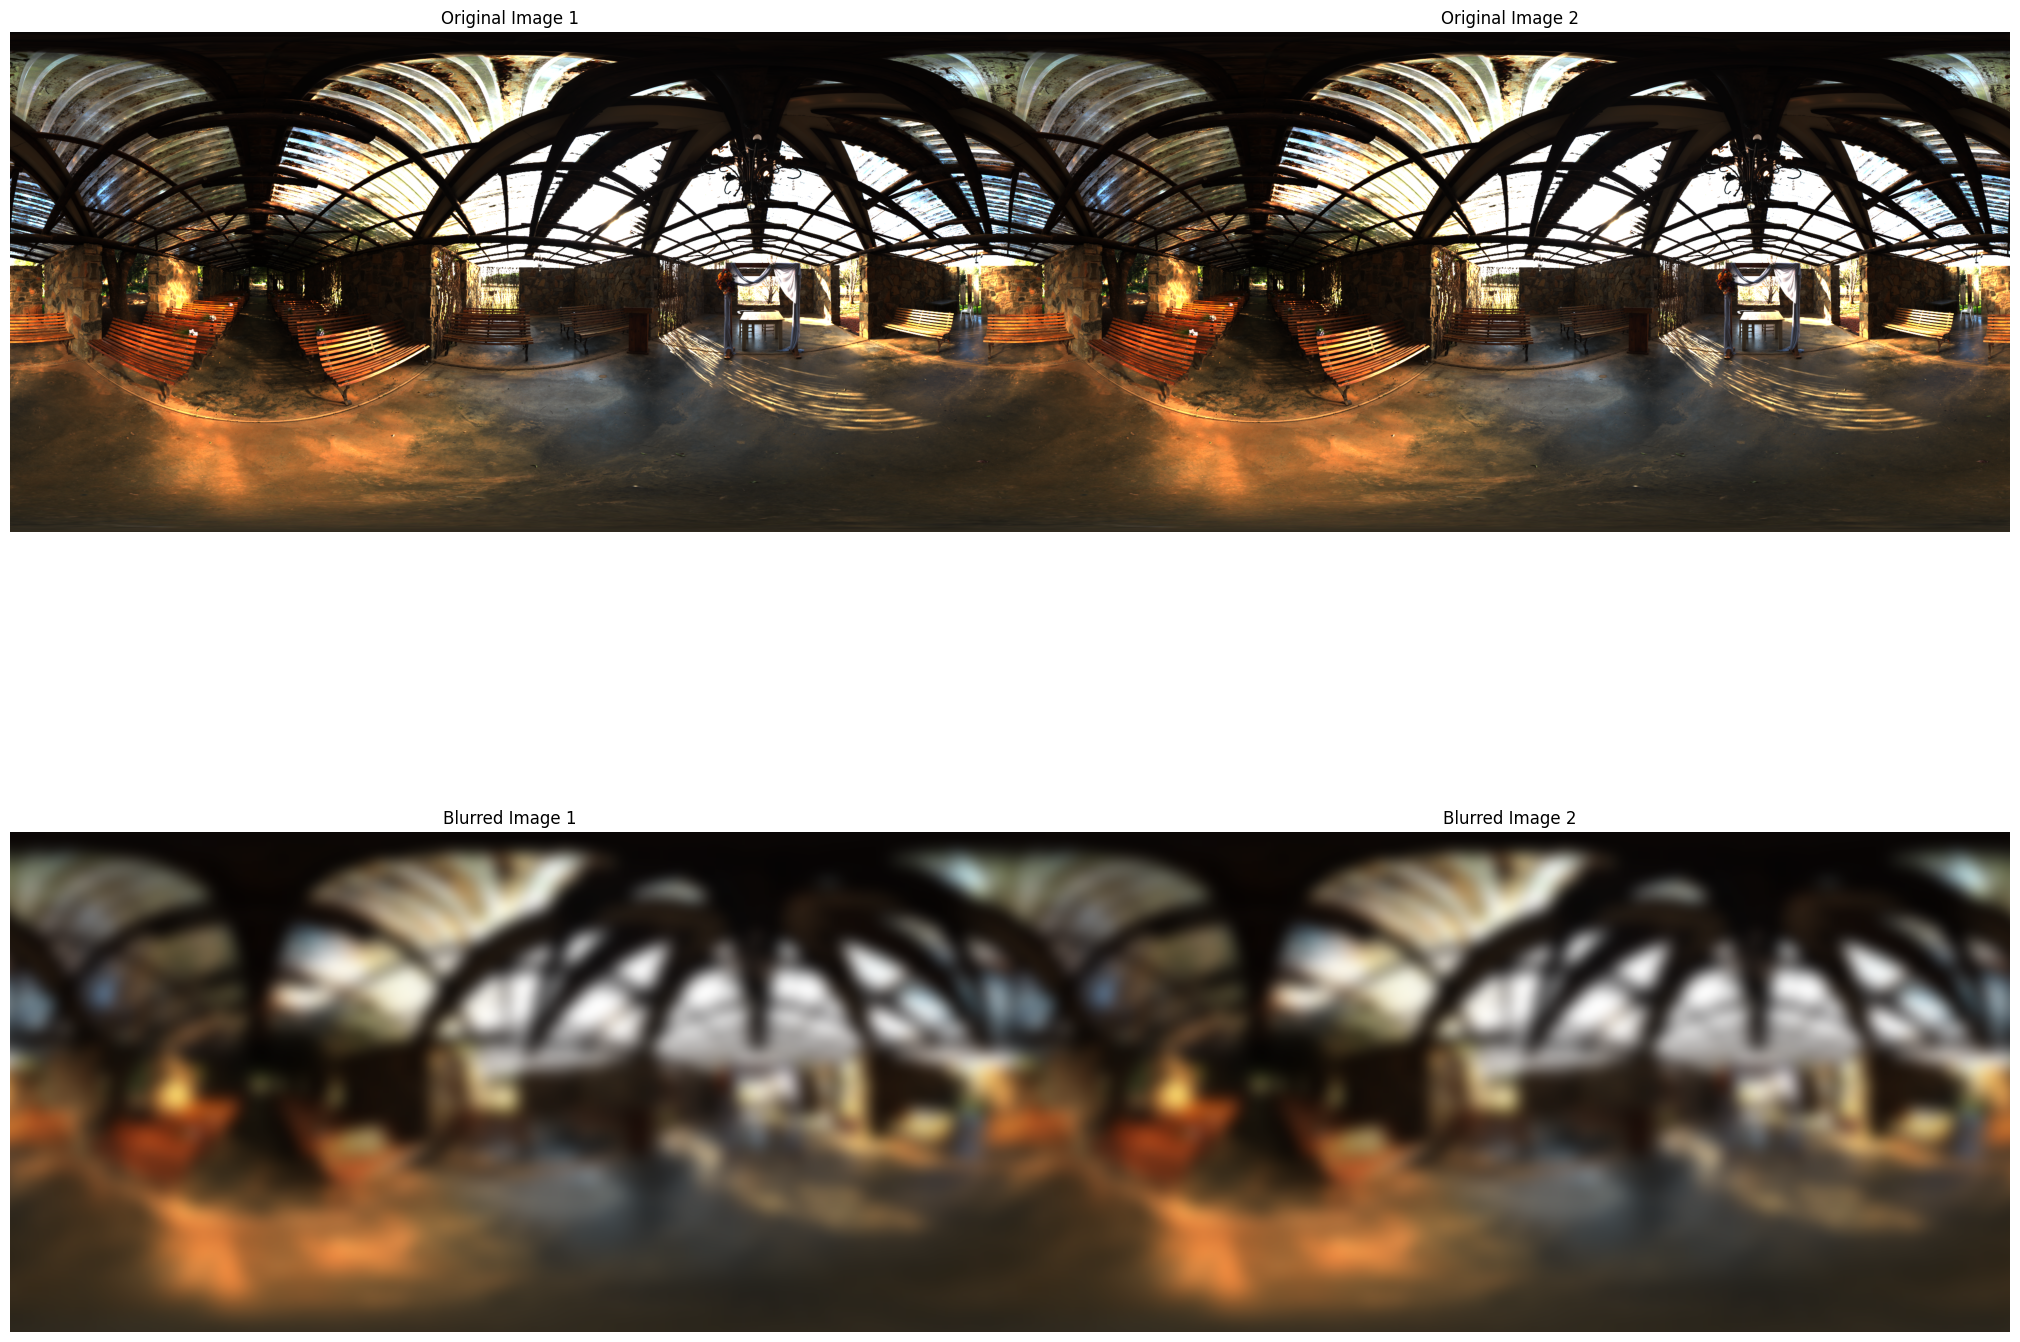

In [5]:
import OpenEXR
import Imath
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

# --- Parameters ---
blur_radius = 15  # controls blur kernel size
padding_size = blur_radius * 2  # padding size is twice the blur radius

# --- Load EXR ---
exr_file = OpenEXR.InputFile("chapel.exr")
header = exr_file.header()
dw = header['dataWindow']
width = dw.max.x - dw.min.x + 1
height = dw.max.y - dw.min.y + 1

FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
red_str = exr_file.channel('R', FLOAT)
green_str = exr_file.channel('G', FLOAT)
blue_str = exr_file.channel('B', FLOAT)

red = np.frombuffer(red_str, dtype=np.float32).reshape((height, width))
green = np.frombuffer(green_str, dtype=np.float32).reshape((height, width))
blue = np.frombuffer(blue_str, dtype=np.float32).reshape((height, width))

img = np.stack([red, green, blue], axis=2)

# --- Normalize to 8-bit for Pillow ---
img_normalized = np.clip(img, 0, 1) * 255
img_uint8 = img_normalized.astype(np.uint8)

# --- Circular wrap-around padding (no mirroring) ---
left_pad = img_uint8[:, -padding_size:]   # copy from right edge
right_pad = img_uint8[:, :padding_size]   # copy from left edge
img_padded = np.hstack([left_pad, img_uint8, right_pad])

# --- Blur padded image ---
img_padded_pil = Image.fromarray(img_padded)
blurred_padded = img_padded_pil.filter(ImageFilter.GaussianBlur(radius=blur_radius))

# --- Crop back to original size ---
blurred_padded_np = np.array(blurred_padded)
blurred_cropped = blurred_padded_np[:, padding_size:-padding_size]

# --- Back to float for saving EXR ---
blurred_img = blurred_cropped.astype(np.float32) / 255.0

# Save blurred image as EXR
blurred_red = blurred_img[:, :, 0]
blurred_green = blurred_img[:, :, 1]
blurred_blue = blurred_img[:, :, 2]

out_header = header.copy()
out_file = OpenEXR.OutputFile("neon_photostudio_2k_blurred.exr", out_header)
out_file.writePixels({
    'R': blurred_red.tobytes(),
    'G': blurred_green.tobytes(),
    'B': blurred_blue.tobytes()
})
out_file.close()

# --- Visualization ---
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16),
                                              subplot_kw={'xticks': [], 'yticks': []})
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

ax1.imshow(img)
ax1.set_title('Original Image 1')
ax1.axis('off')

ax2.imshow(img)
ax2.set_title('Original Image 2')
ax2.axis('off')

ax3.imshow(blurred_img)
ax3.set_title('Blurred Image 1')
ax3.axis('off')

ax4.imshow(blurred_img)
ax4.set_title('Blurred Image 2')
ax4.axis('off')

plt.show()